In [1]:
# Import packages

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import ticker
from matplotlib import rc
import seaborn as sns

# Set the global font to be Arial, size 10
rc('font',**{'family':'sans-serif','sans-serif':['Arial'],'size':10})

# Package to read xml files
from xml.etree import cElementTree as ET

In [2]:
# This function was adopted from Paulo Caldas, please see: 
# https://github.com/paulocaldas/How-to-Python/blob/master/Read%20XML%20files%20and%20Plot%20Trajectories%20from%20TrackMate.ipynb


def read_trackmate_xml_tracks(xml_file):
    """Reads tracks from trackmate xml track file and returns a DataFrame 
    in similar format as the trackmate csv, plus the frame interval is returned"""
    
    tracks = ET.parse(xml_file)
    frame_interval = float(tracks.getroot().attrib["frameInterval"])
    
    attributes = []
    for ti, track in enumerate(tracks.iterfind('particle')):
        for spots in track.iterfind('detection'):
            attributes.append([ti, int(spots.attrib.get('t')),
                                   float(spots.attrib.get('x')),
                                   float(spots.attrib.get('y'))])
#         attributes[ti].append(int(track.attrib.get('nSpots')))
        

    track_table = pd.DataFrame(attributes, columns=['TRACK_ID','FRAME','POSITION_X','POSITION_Y'])
    
    return track_table, frame_interval, attributes
    print(attributes)

In [4]:
data = "3B_example_data_GTP_trajectories.xml"

table_gtp, frame_interval, attributes = read_trackmate_xml_tracks(data)
print(table_gtp.head(3), '\n...') # Take a look at the table format
print("Number of tracks:", table_gtp['TRACK_ID'].values[-1]+1)

   TRACK_ID  FRAME  POSITION_X  POSITION_Y
0         0      0   27.375459    0.200328
1         0      1   27.336000    0.000000
2         0      2   27.744000    0.000000 
...
Number of tracks: 671


C:\Users\ubezelja\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


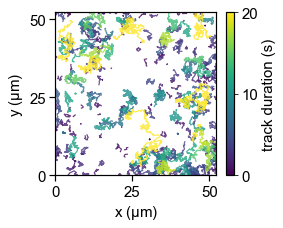

In [41]:
# Generate a table with 500 random tracks.

rndm_tracks = np.random.randint(0, table_gtp['TRACK_ID'].values[-1]+1, 500)
rndm_table_gtp = table_gtp.loc[table_gtp['TRACK_ID'].isin(rndm_tracks)]

# Sort the tracks by their length.

rndm_table_gtp['TRACK_LENGHT'] = rndm_table_gtp.groupby('TRACK_ID')['TRACK_ID'].transform(lambda track: len(track))
new_sorted_table_gtp = rndm_table_gtp.sort_values(by = ['TRACK_LENGHT','FRAME'], ascending = True)

truncate = -1 # Truncate number of spots to plot if necessary , -1 plots all spots/trajectories.

# Plot settings.

fig, ax = plt.subplots(figsize=(3.6,3))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.tick_params(width=1.2)
plt.setp(ax.spines.values(), linewidth=1.2)

ax.tick_params('both', length=6, width=1.2, which='major')
ax.tick_params('both', length=4, width=1.2, which='minor')

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.2)

# Axis settings.

plt.xlabel('x ($\mu{}$m)', fontsize=15)
plt.ylabel('y ($\mu{}$m)', fontsize=15)
locy = ticker.MultipleLocator(base=25) # this locator puts ticks at regular intervals
ax.yaxis.set_major_locator(locy)
locx = ticker.MultipleLocator(base=25) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(locx)

# Plot dimensions. The aquired field of view is 512 x 512 px at 0.102 um resolution.

plt.xlim([0,0.102*512])
plt.ylim([0,0.102*512])

# Pick a colormap

cm = plt.get_cmap('viridis')

# Plot the trajectories and normalize their color by their length. The aquisition frequency was 10 Hz (100 ms), so the track lengths are divided by 200 for time scale 0-20 s.

for groups, columns in new_sorted_table_gtp[:truncate].groupby('TRACK_ID', sort = False):
    color = cm(columns['TRACK_LENGHT'].values[0]/200)
    trajectories = plt.plot(columns['POSITION_X'],columns['POSITION_Y'], lw = 1.2, alpha = 0.8,color = color)

# Colorbar legend

norm = mpl.colors.Normalize(vmin=0,vmax=20)
sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ticks=np.linspace(0,20,3))
cbar.outline.set_linewidth(1.2)
ticklabs = cbar.ax.get_yticklabels()
cbar.ax.set_yticklabels(ticklabs, fontsize=15)
cbar.set_label('track duration (s)', fontsize=15)
    
plt.rcParams.update({'mathtext.default':  'regular', "svg.fonttype": 'none' })

# plt.savefig('fig3B_GTP.svg', format='svg', bbox_inches='tight',edgecolor='none')
# plt.savefig('fig3B_GTP.png', format='png', bbox_inches='tight',edgecolor='none', dpi = 150)